# Classifier

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.enable_eager_execution()
AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load index csv

In [2]:
# TODO update dataset
dataset_index = pd.read_csv('./dataset/tiles-data/data.csv')
print(dataset_index.shape)
print(dataset_index.head())

dataset_size = dataset_index.shape[0]
num_classes = np.amax(dataset_index['label'])

# append path prefix
dataset_index['image-path'] = './dataset/tiles-resized/' + dataset_index['image-name']
print(dataset_index.shape)
print(dataset_index.head())

# shuffle
dataset_index = dataset_index.reindex(np.random.permutation(dataset_index.index))
print(dataset_index.shape)
print(dataset_index.head())

(629, 3)
  image-name  label    label-name
0      1.jpg     38  bonus-winter
1      2.jpg     26  characters-8
2      3.jpg      9        dots-9
3      4.jpg     36  bonus-summer
4      5.jpg     28   honors-east
(629, 4)
  image-name  label    label-name                     image-path
0      1.jpg     38  bonus-winter  ./dataset/tiles-resized/1.jpg
1      2.jpg     26  characters-8  ./dataset/tiles-resized/2.jpg
2      3.jpg      9        dots-9  ./dataset/tiles-resized/3.jpg
3      4.jpg     36  bonus-summer  ./dataset/tiles-resized/4.jpg
4      5.jpg     28   honors-east  ./dataset/tiles-resized/5.jpg
(629, 4)
    image-name  label    label-name                       image-path
593    593.jpg     40  bonus-orchid  ./dataset/tiles-resized/593.jpg
73      74.jpg     10      bamboo-1   ./dataset/tiles-resized/74.jpg
460    461.jpg     14      bamboo-5  ./dataset/tiles-resized/461.jpg
35      36.jpg     22  characters-4   ./dataset/tiles-resized/36.jpg
578    579.jpg     11      bamboo-

## Load and rotate images

Instructions for updating:
Colocations handled automatically by placer.


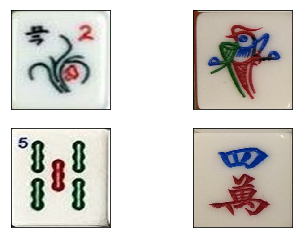

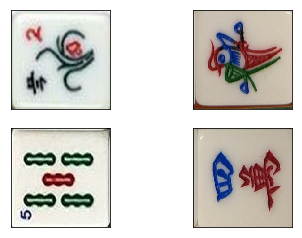

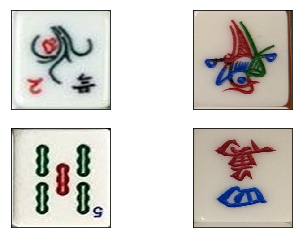

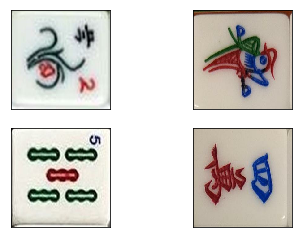

In [3]:
def show_image_sample(ds):
    for n,image in enumerate(ds.take(4)):
        plt.subplot(2,2,n+1)
        plt.imshow(image)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
    plt.show()

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

path_ds = tf.data.Dataset.from_tensor_slices(dataset_index['image-path'])
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds)

def rotate_image(image):
    image = tf.image.rot90(image)
    return image

image_ds_90 = image_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_90)

image_ds_180 = image_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_180)

image_ds_270 = image_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
show_image_sample(image_ds_270)

dataset_size *= 4

## Create image-label pairs

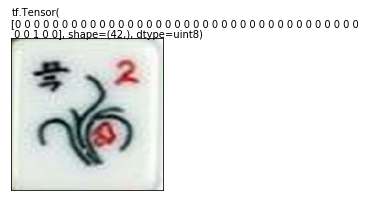

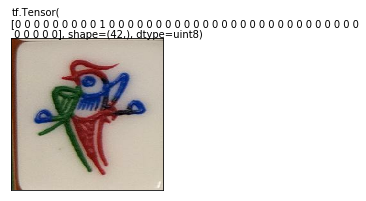

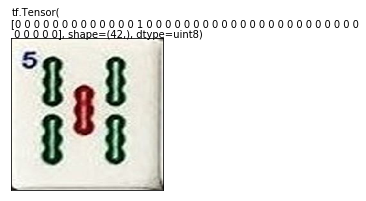

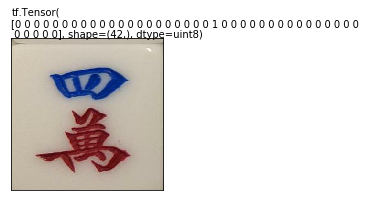

(TensorShape([Dimension(320), Dimension(320), Dimension(3)]), TensorShape([Dimension(42)]))


In [4]:
label_offset = tf.math.subtract(dataset_index['label'], 1) # Offset index by 1
label_one_shot = tf.one_hot(label_offset, num_classes)
image_label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(label_one_shot, tf.uint8))

all_image_ds = image_ds.concatenate(image_ds_90).concatenate(image_ds_180).concatenate(image_ds_270)
all_image_label_ds = image_label_ds.concatenate(image_label_ds).concatenate(image_label_ds).concatenate(image_label_ds)

all_ds = tf.data.Dataset.zip((all_image_ds, all_image_label_ds))

for n, (image, label) in enumerate(all_ds.take(4)):
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.text(1, 0, label)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

print(all_ds.output_shapes)

## Split train test

In [5]:
# train-test split
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15) # test has 0.15 as well

print("train size:", train_size)
print("val size:", val_size)

train_ds = all_ds.take(train_size)
test_ds = all_ds.skip(train_size)
val_ds = test_ds.take(val_size)
test_ds = test_ds.skip(val_size)

train size: 1761
val size: 377


## Load Encoder

In [6]:
encoder = keras.Sequential(layers=[
    keras.layers.BatchNormalization(input_shape=(320,320,3)),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='selu'),
], name='encoder')

# Load weight
encoder.load_weights(filepath='./models/encoder.h5', by_name=True)

for layer in encoder.layers:
    layer.trainable = False

## FC

In [7]:
fc = keras.Sequential(layers=[
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(num_classes, activation='softmax')
], name='fc')

## Train the model

In [8]:
batch_size = 32

train_ds_batch = train_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=val_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

classifier = keras.Sequential([encoder, fc])
classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# encoder.summary()
# fc.summary()
# classifier.summary()

classifier.fit(train_ds_batch.make_one_shot_iterator(),
               epochs=2,
               steps_per_epoch=int(train_size/batch_size),
               validation_data=val_ds_batch.make_one_shot_iterator(),
               validation_steps=int(val_size/batch_size),
               callbacks=[keras.callbacks.TensorBoard(log_dir='./logs')]
       )

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/2
Instructions for updating:
Use tf.cast instead.
55/55 [==============================] - 16s 297ms/step - loss: 4.1383 - acc: 0.2256 - val_loss: 4.2996 - val_acc: 0.2585
Epoch 2/2
55/55 [==============================] - 7s 120ms/step - loss: 2.2370 - acc: 0.4574 - val_loss: 3.0327 - val_acc: 0.3153


In [9]:
test_ds_batch = test_ds.batch(batch_size).repeat().prefetch(AUTOTUNE)

classifier.evaluate(test_ds_batch.make_one_shot_iterator(), steps=1)

1/1 [==============================] - 4s 4s/step - loss: 3.2398 - acc: 0.3438


[3.2397584915161133, 0.34375]